In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.math.toccd import toccd

from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator

def create_field_from_zernike_coefficients(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase = project_zernike_on_mask(mask, noll_ids, amplitudes)
    amp = xp.asarray(mask.asTransmissionValue())
    return  amp * xp.exp(1j * phase)


def project_zernike_on_mask(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    zg = ZernikeGenerator(mask)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(noll))
    else:
        amplitudes *= xp.ones(len(noll_ids))
        zern = xp.zeros(mask.mask().shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(noll))

    return zern

In [3]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], cmap='twilight')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.asnumpy(xp.log(image[roi[0]: roi[1], roi[0]:roi[1]]))
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

def tilt_field(pyr, field, tiltAmpX, tiltAmpY):
    tiltX,tiltY = pyr._get_XY_tilt_planes(field.shape)
    wedge_tilt = (tiltX*tiltAmpX + tiltY*tiltAmpY)*(2*xp.pi)#*pyr.oversampling
    focal_plane_field = xp.fft.fftshift(xp.fft.fft2(field))
    field = focal_plane_field * xp.exp(1j*wedge_tilt)#, dtype=pyr.cdtype)
    field = xp.fft.ifft2(xp.fft.ifftshift(field))
    return field

def radial_order_from_noll(noll):
    return xp.ceil(-3.0/2.0+xp.sqrt(1+8*noll)/2.0)

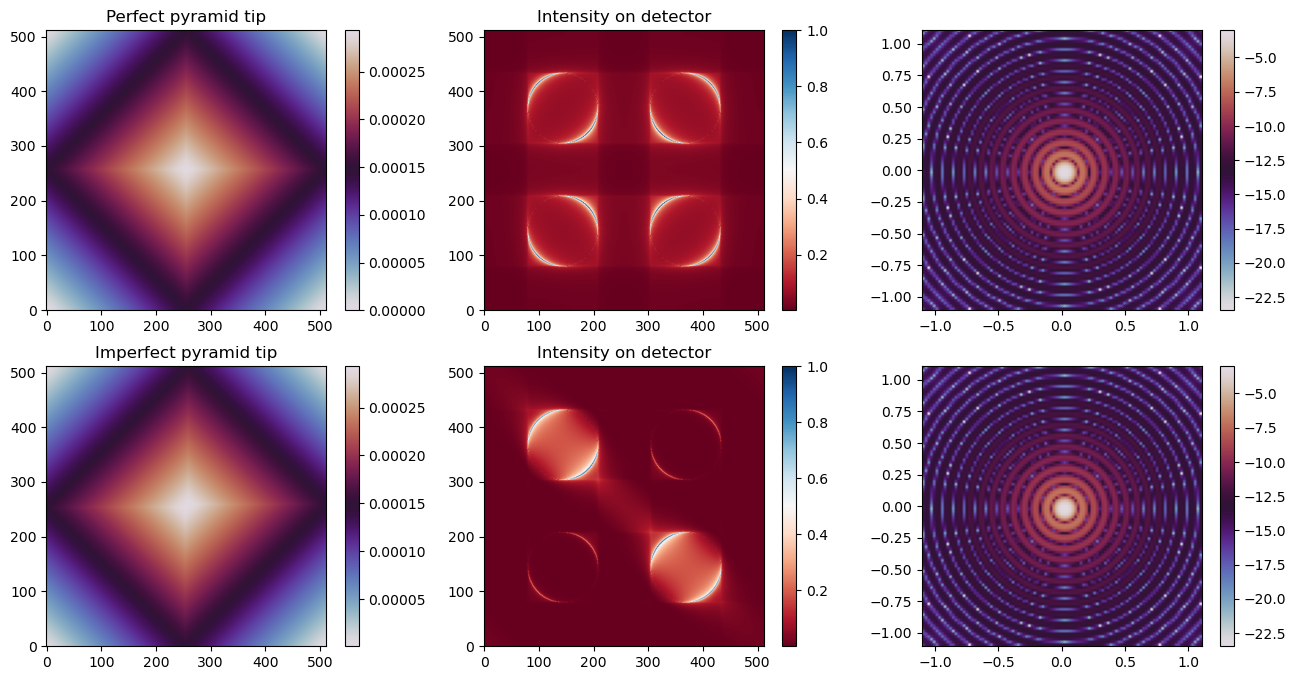

In [4]:
Npix = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

# Conversions
pupilDiameterInM = 1.8
lambdaInM = 750e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec
lambdaOverD = lambdaInM/pupilDiameterInM

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)
padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)

# Pyramid WFS
apex_angle = 112*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)

# Compute perfect pyramid psf
output_field = wfs.propagate(padded_field, lambdaOverD)
intensity = xp.abs(output_field**2)
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Imperfect pyramid
roof = 2
wfs_roof = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM, roofSize=roof)

# Compute imperfect pyramid psf
output_field = wfs_roof.propagate(padded_field, lambdaOverD)
roof_intensity = xp.abs(output_field**2)
roof_psf = xp.abs(xp.abs(wfs_roof.field_on_focal_plane**2))
roof_psf *= 1/xp.sum(roof_psf)


plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.imshow(xp.asnumpy(wfs.pyramid_phase_delay((Npix*oversampling,Npix*oversampling))), origin='lower', cmap='twilight')
plt.colorbar()
plt.title('Perfect pyramid tip')
plt.subplot(2,3,3)
showZoomCenter(psf, pixelSize=pix2arcsec)
plt.subplot(2,3,2)
plt.title("Intensity on detector")
plt.imshow(xp.asnumpy(intensity/xp.max(intensity)),origin='lower',cmap='RdBu')
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(xp.asnumpy(wfs_roof.pyramid_phase_delay((Npix*oversampling,Npix*oversampling))), origin='lower', cmap='twilight')
plt.colorbar()
plt.title('Imperfect pyramid tip')
plt.subplot(2,3,6)
showZoomCenter(roof_psf, pixelSize=pix2arcsec)
plt.subplot(2,3,5)
plt.title("Intensity on detector")
plt.imshow(xp.asnumpy(roof_intensity/xp.max(roof_intensity)),origin='lower',cmap='RdBu')
plt.colorbar()

Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps


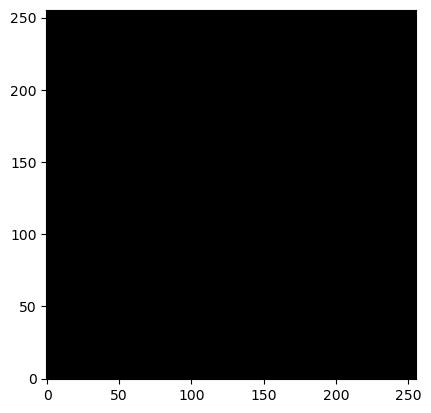

In [5]:
detector_shape = (256,256)
ccd = Detector(detector_shape=detector_shape)

sc = SlopeComputer(wfs, ccd, {'modulationInLambdaOverD':0})
sc.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=xp.asarray(mask.asTransmissionValue()), lambdaOverD=lambdaOverD, Npix=63, centerObscurationInPixels=0.0)
subapertures = sc._roi_masks

roof_sc = SlopeComputer(wfs_roof, ccd, {'modulationInLambdaOverD':0})
roof_sc.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=xp.asarray(mask.asTransmissionValue()), lambdaOverD=lambdaOverD, Npix=63, centerObscurationInPixels=0.0)
roof_subapertures = roof_sc._roi_masks

plt.figure()
plt.imshow(xp.asnumpy(xp.sum(1-subapertures,axis=0)-xp.sum(1-roof_subapertures,axis=0)),origin='lower',cmap='grey')


Modulating 0 [lambda/D] with 0 modulation steps
51.277274034852056 2.9672300282100528
0


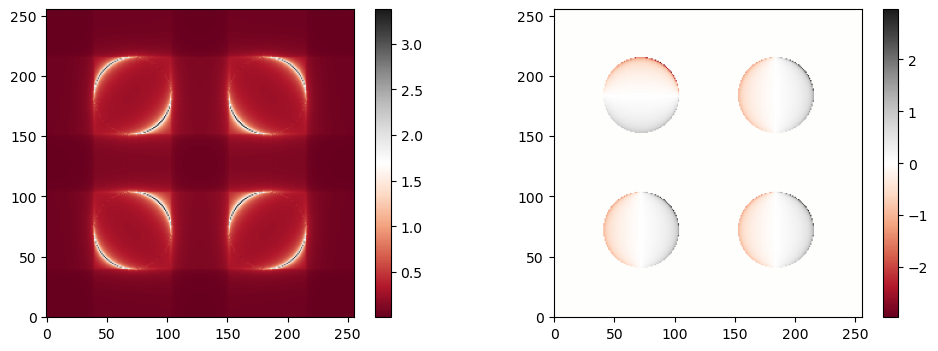

In [6]:
input_field = create_field_from_zernike_coefficients(mask, 1, 0)

wfs.set_modulation_angle(0)
sc.compute_slope_null(input_field, lambdaOverD)

Nmin = 1*(sc._slope_method=='slopes') + 2*(sc._slope_method=='diagonal_slopes') + 3*(sc._slope_method=='raw_intensity')

ref_image = xp.zeros([subapertures.shape[1],subapertures.shape[2]])
for k,subap in enumerate(subapertures):
    ref_image[~subap] = sc.slope_null[min(Nmin,k)*xp.sum(1-subap):min(Nmin+1,k+1)*xp.sum(1-subap)]

print(xp.sum(ref_image)/4,xp.max(ref_image))
print(sc._wfs.modulationAngleInLambdaOverD)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(ccd.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(ref_image),origin='lower',cmap='RdGy')
plt.colorbar()

Modulating 0 [lambda/D] with 0 modulation steps
-4.772836470893822 2.7185272848379793
0


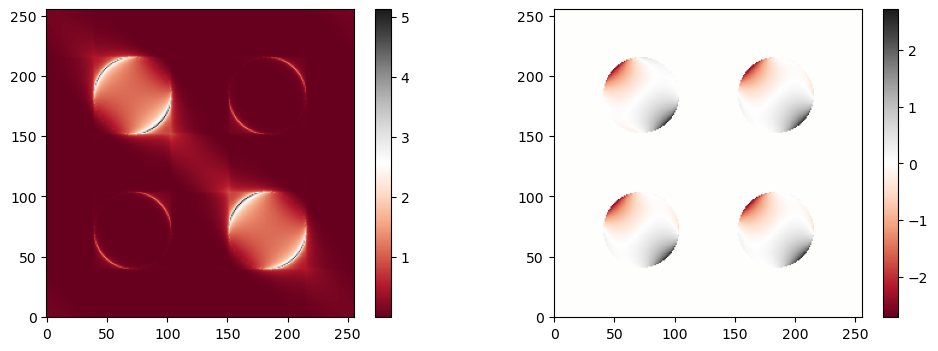

In [7]:
input_field = create_field_from_zernike_coefficients(mask, 1, 0)

wfs_roof.set_modulation_angle(0)
roof_sc.compute_slope_null(input_field, lambdaOverD)

Nmin = 1*(roof_sc._slope_method=='slopes') + 2*(roof_sc._slope_method=='diagonal_slopes') + 3*(roof_sc._slope_method=='raw_intensity')

ref_image = xp.zeros([roof_subapertures.shape[1],roof_subapertures.shape[2]])
for k,subap in enumerate(roof_subapertures):
    ref_image[~subap] = roof_sc.slope_null[min(Nmin,k)*xp.sum(1-subap):min(Nmin+1,k+1)*xp.sum(1-subap)]

print(xp.sum(ref_image)/4,xp.max(ref_image))
print(roof_sc._wfs.modulationAngleInLambdaOverD)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(ccd.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(ref_image),origin='lower',cmap='RdGy')
plt.colorbar()

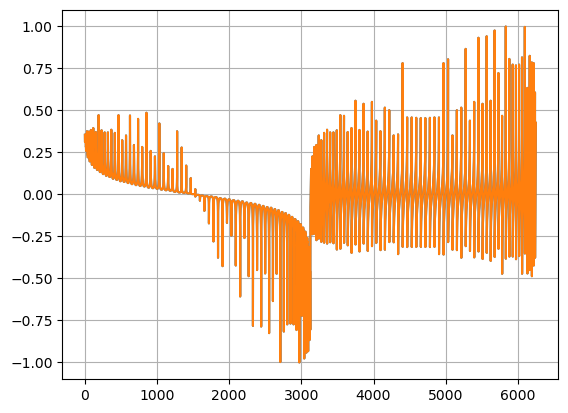

In [8]:
Cn = sc.define_cramer_rao_matrix(sc.slope_null, nPhotons=1000, RON=0.3, Npupils=4)
plt.figure()
plt.plot(xp.asnumpy(xp.diag(Cn)/xp.max(Cn)))
plt.plot(xp.asnumpy(sc.slope_null/xp.max(sc.slope_null)))
plt.grid()

In [9]:
def push_pull_calibrate(sc1, sc2, Nmodes, method:str='slopes', amp:float = 0.02):
    
    match method:
        case 'slopes':
            Ns = 2
        case 'diagonal_slopes':
            Ns = 3
        case 'raw_intensity':
            Ns = 4
    
    slope_len = int(xp.sum(1-sc1._roi_masks[0])*Ns)
    IM1 = xp.zeros((slope_len,Nmodes))
    IM2 = xp.zeros((slope_len,Nmodes))
    nx = 128
    mask = CircularMask((nx,nx), maskRadius=nx // 2)
    sc1.slope_null = None
    sc2.slope_null = None
    sc1._slope_method = method
    sc2._slope_method = method

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        push_slope1 = sc1.compute_slopes(input_zern, lambdaOverD, nPhotons=None)/amp
        pull_slope1 = sc1.compute_slopes(xp.conj(input_zern), lambdaOverD, nPhotons=None)/amp

        push_slope2 = sc2.compute_slopes(input_zern, lambdaOverD, nPhotons=None)/amp
        pull_slope2 = sc2.compute_slopes(xp.conj(input_zern), lambdaOverD, nPhotons=None)/amp

        if noll <= 16:
            plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            plt.plot(xp.asnumpy(push_slope1))
            plt.plot(xp.asnumpy(push_slope2))
            plt.grid()
            plt.subplot(1,3,2)
            plt.plot(xp.asnumpy(pull_slope1))
            plt.plot(xp.asnumpy(pull_slope2))
            plt.title(f'Noll {noll}')
            plt.grid()
            plt.subplot(1,3,3)
            plt.plot(xp.asnumpy((push_slope1-pull_slope1)/2))
            plt.plot(xp.asnumpy((push_slope2-pull_slope2)/2))
            plt.grid()

        IM1[:,i] = (push_slope1-pull_slope1)/2
        IM2[:,i] = (push_slope2-pull_slope2)/2

    Rec1 = xp.linalg.pinv(IM1)
    Rec2 = xp.linalg.pinv(IM2)

    return Rec1, IM1, Rec2, IM2

Modulating 0 [lambda/D] with 0 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps


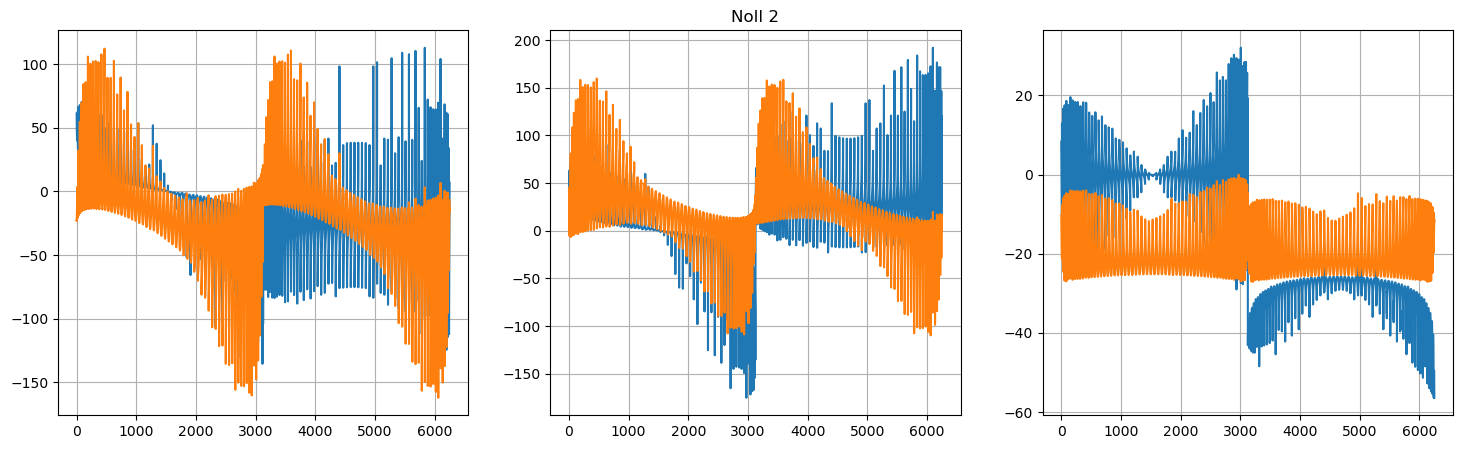

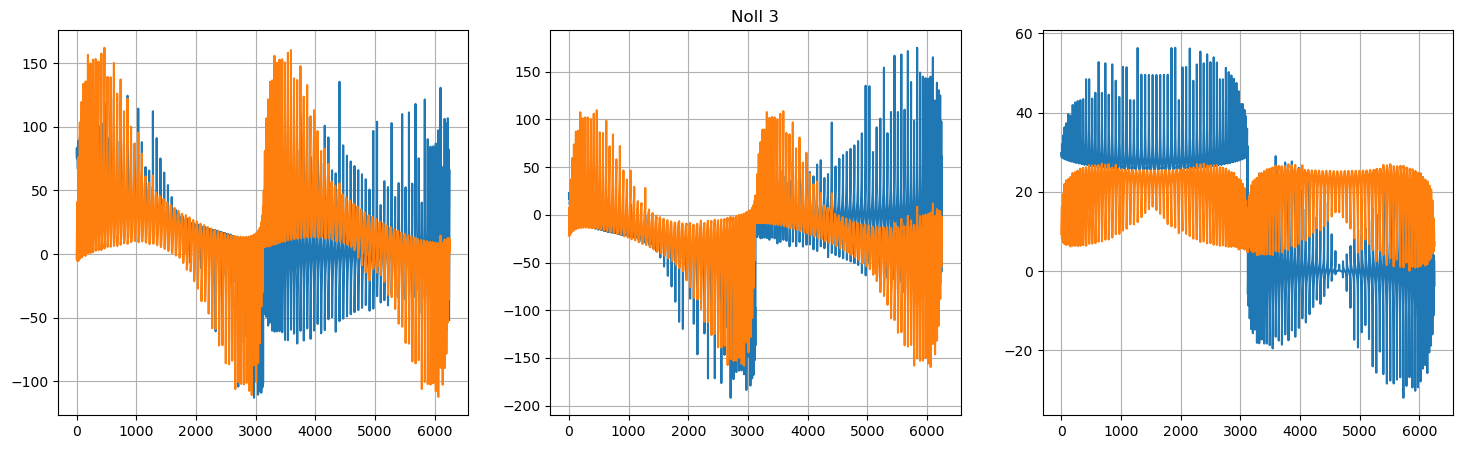

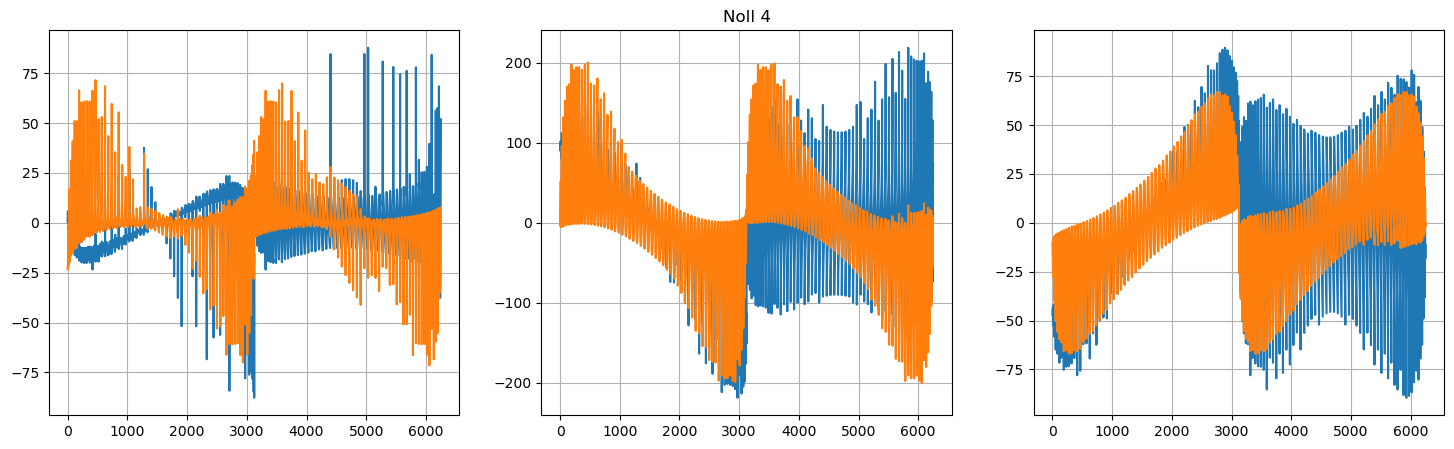

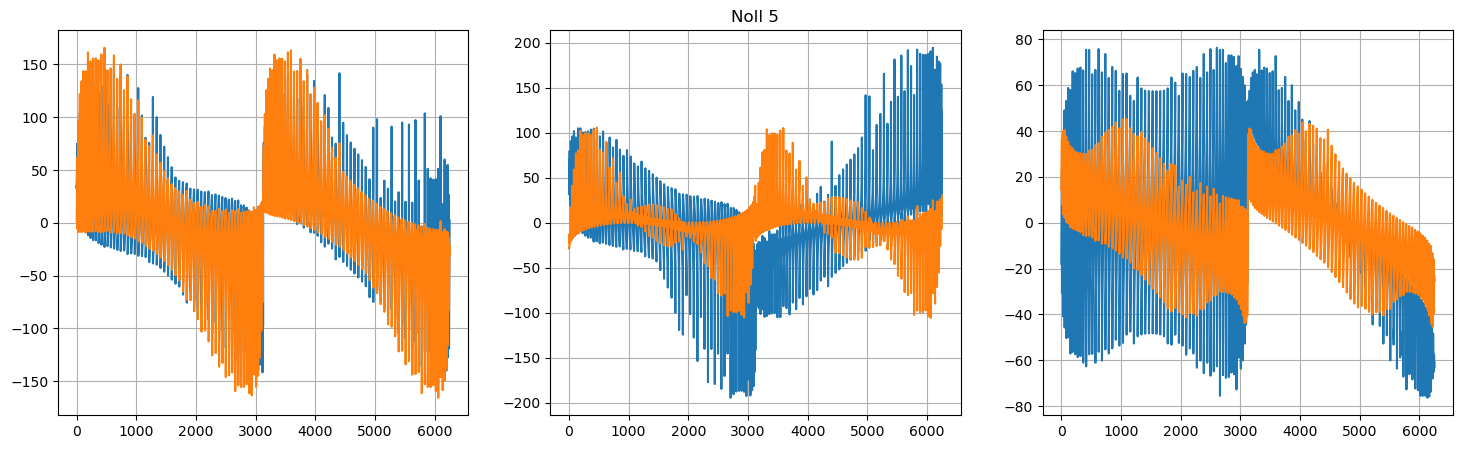

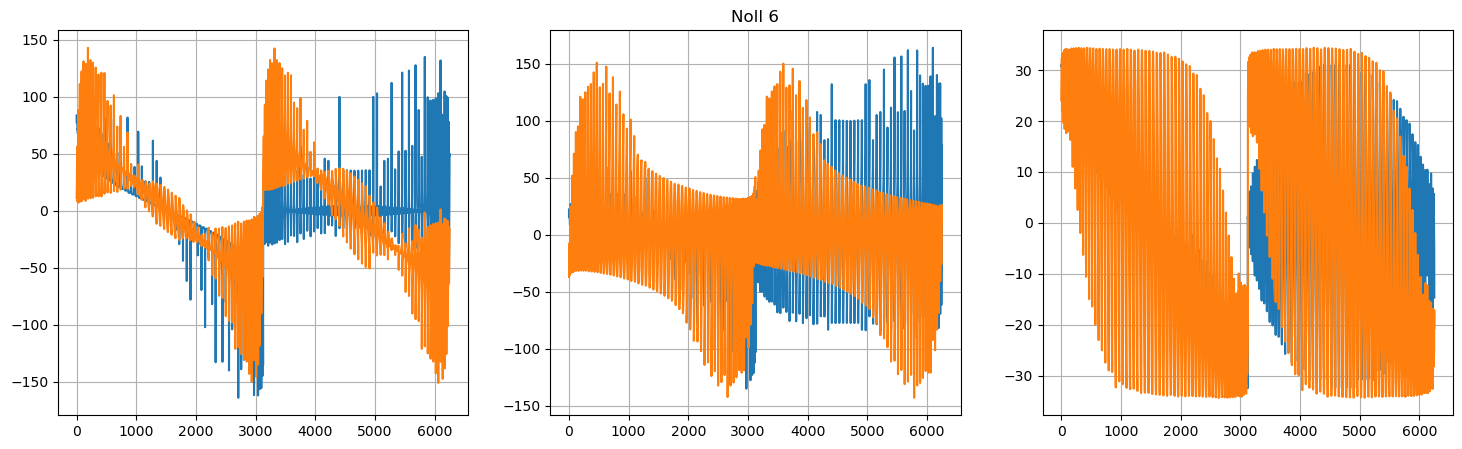

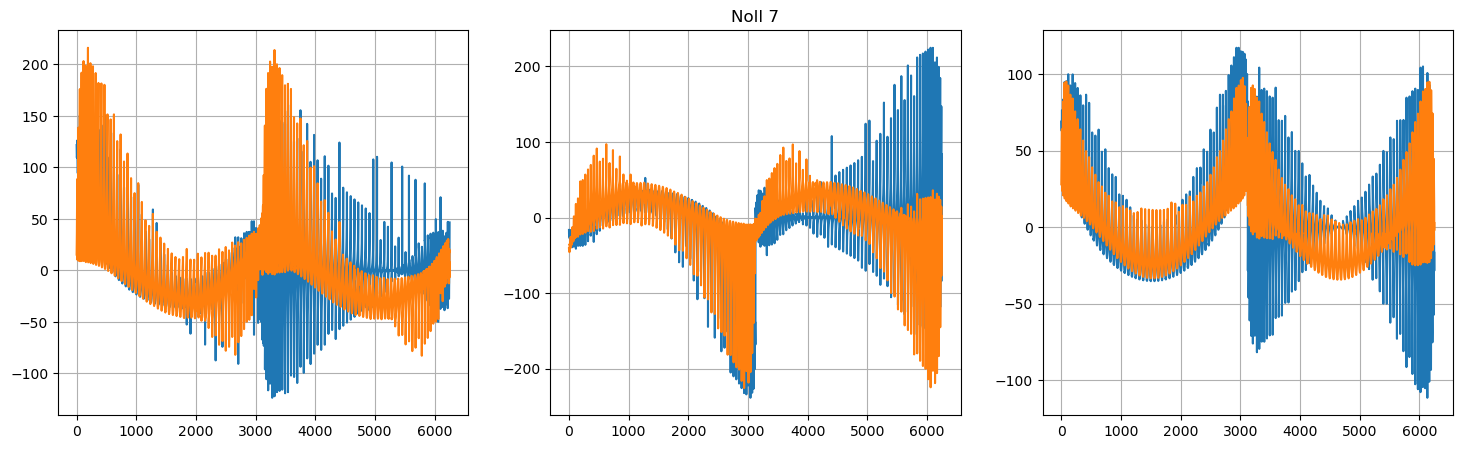

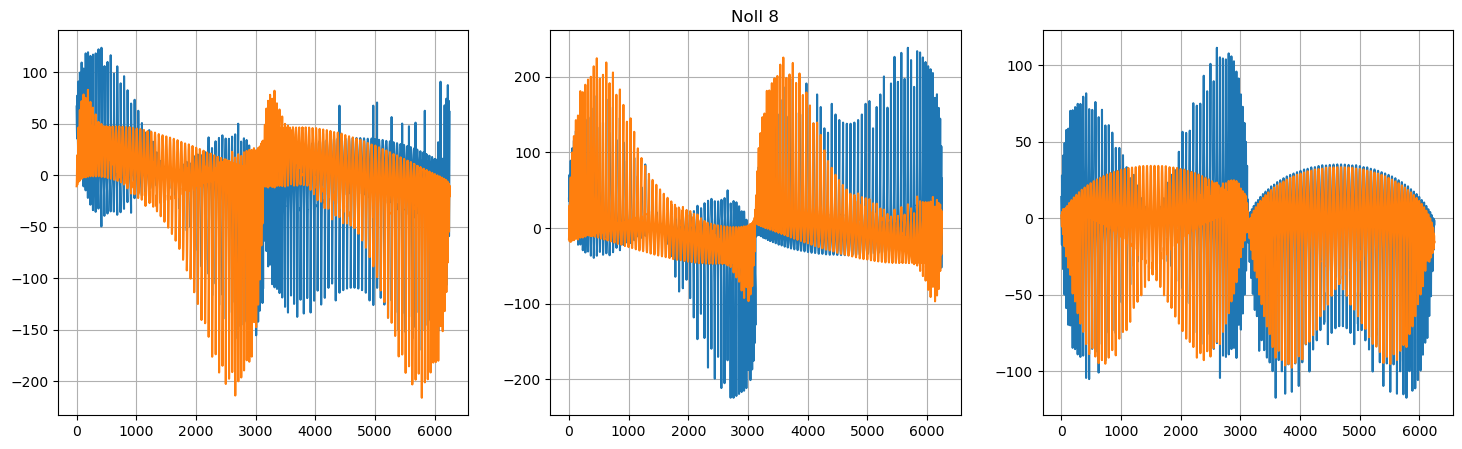

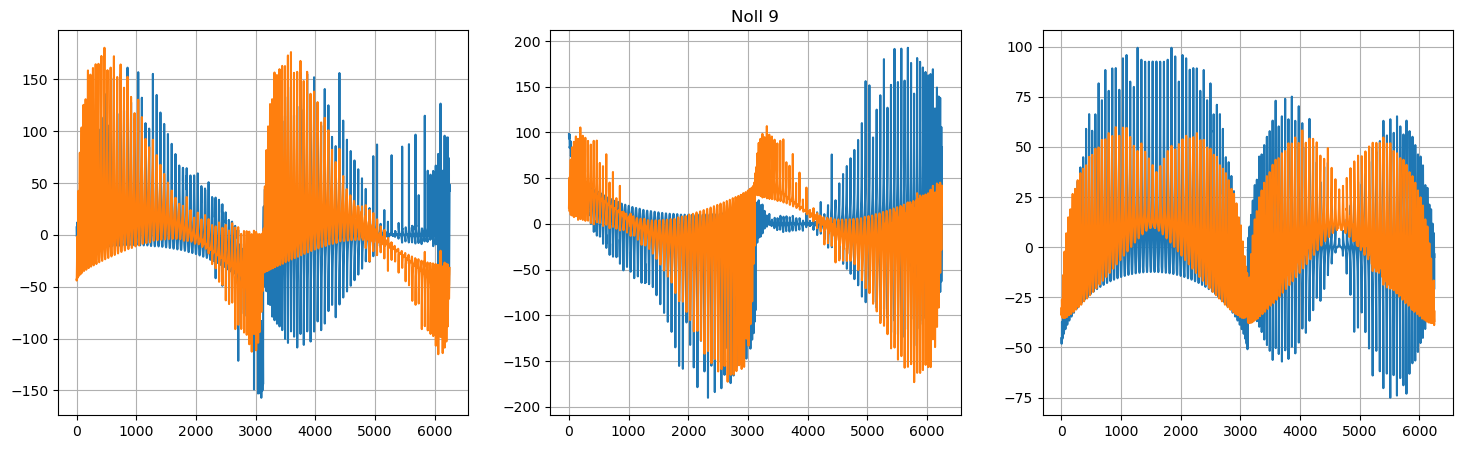

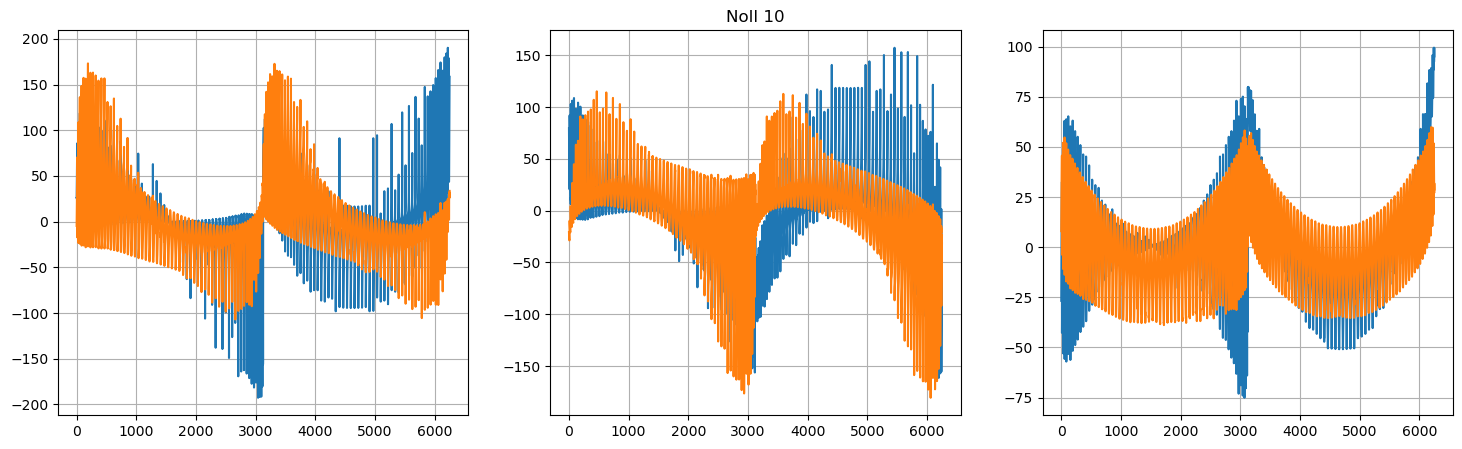

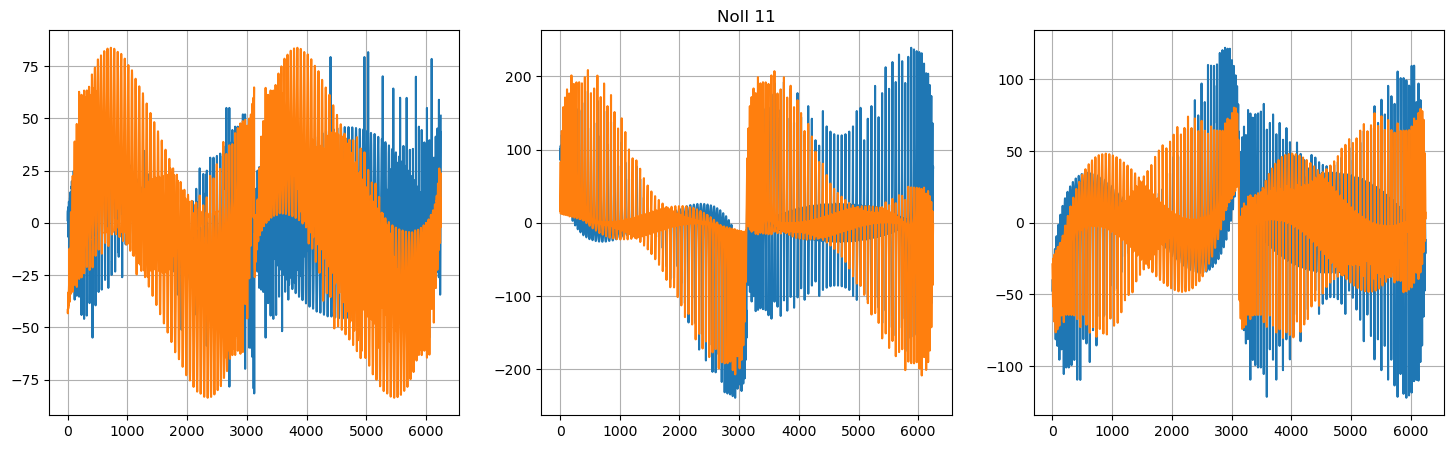

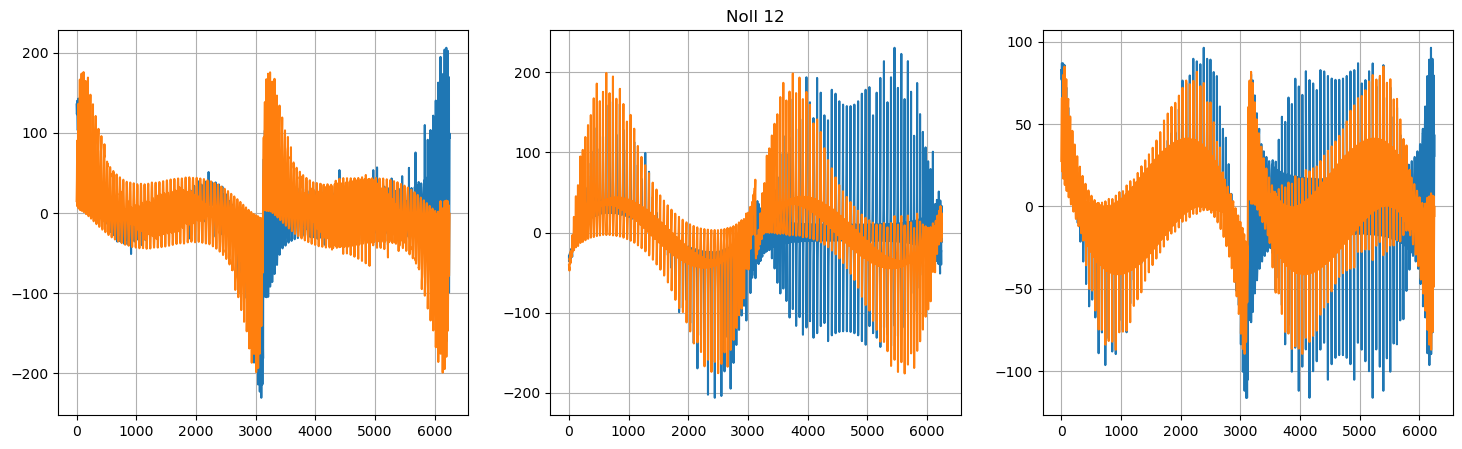

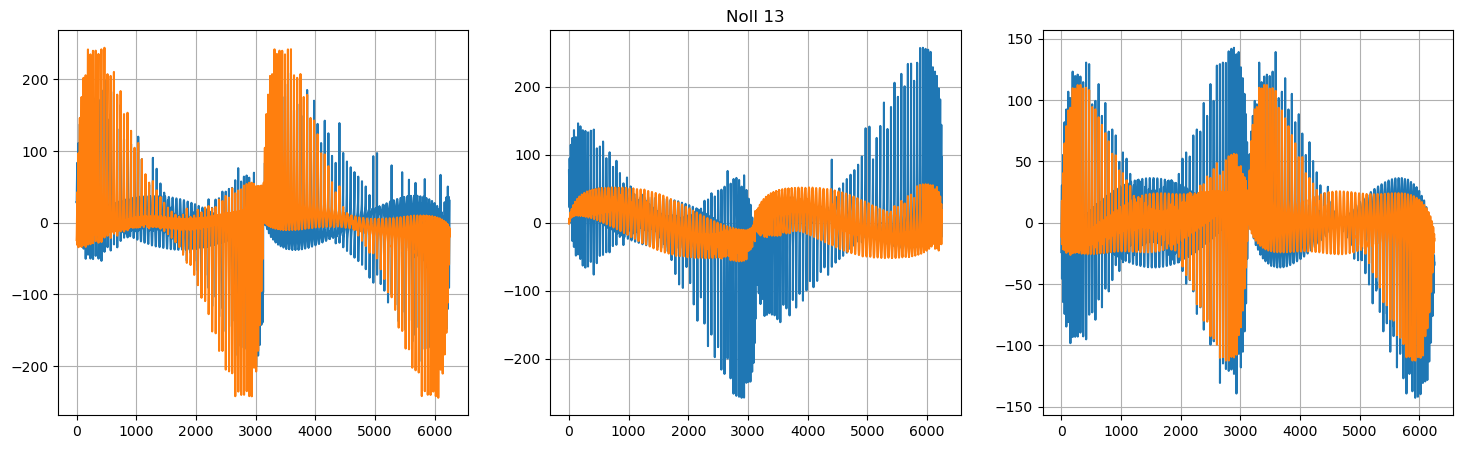

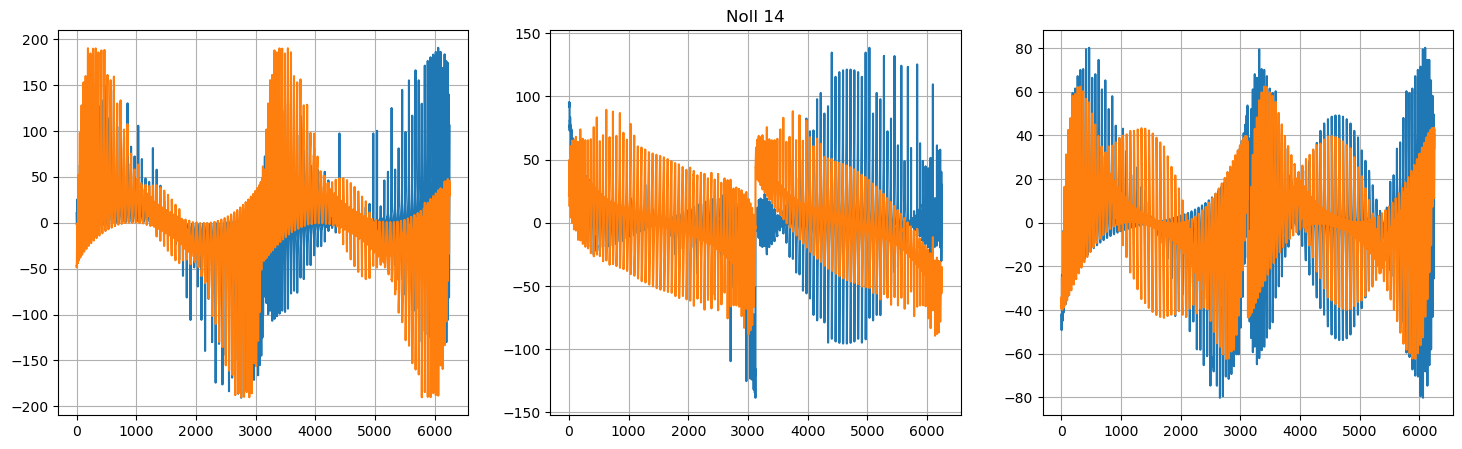

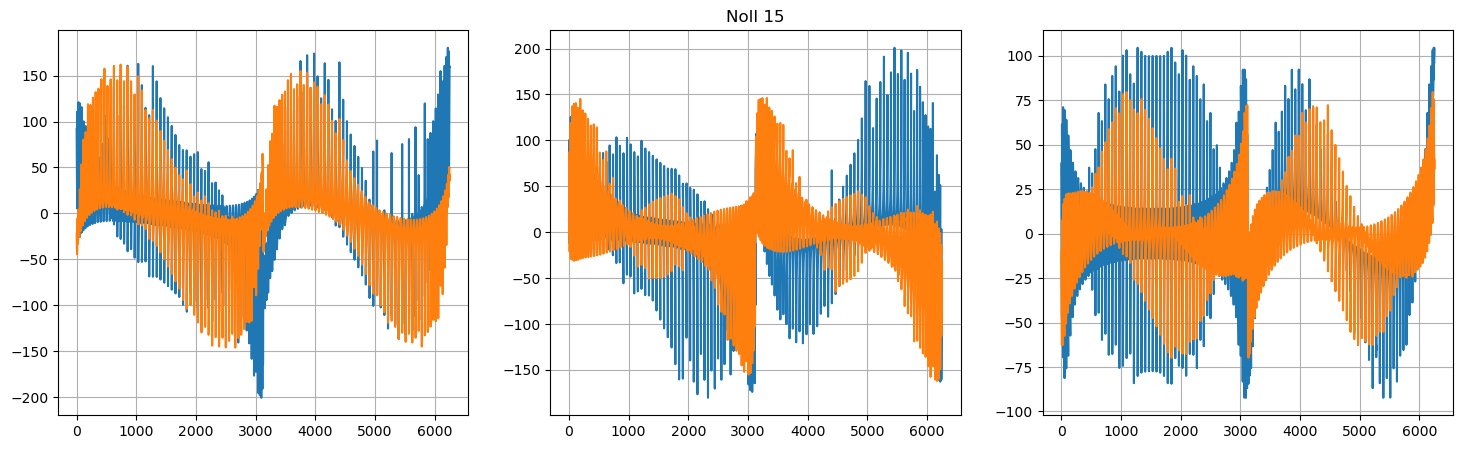

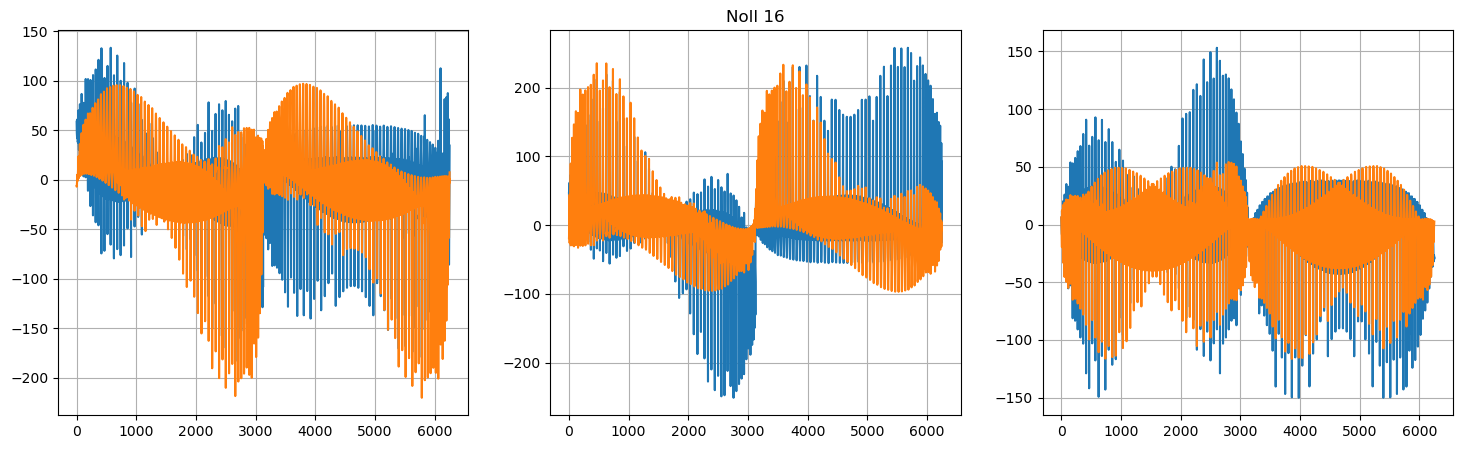

In [10]:
N = 6
nRecModes = int((N+1)*N/2)

method='slopes'
# method='diagonal_slopes'
# method='raw_intensity'

wfs.set_modulation_angle(0)
wfs_roof.set_modulation_angle(0)
Rec,IM,Rec_roof,IM_roof = push_pull_calibrate(sc, roof_sc, nRecModes, method=method)


(6250, 21) (6250, 6250)


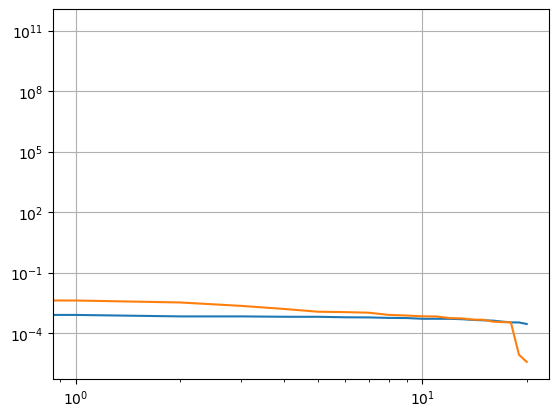

In [11]:
# U,D,V = xp.linalg.svd(IM,full_matrices=False)
print(IM.shape, Cn.shape)
aux = Cn @ IM
aux = IM.T @ aux
aux2 = IM.T @ Cn
mlRec = xp.linalg.pinv(aux) @ aux2

# plt.figure()
# plt.imshow(xp.asnumpy(Rec-mlRec),origin='lower',cmap='RdGy')
# plt.xlim([0,200])
# plt.colorbar()

U,D,V = xp.linalg.svd(Rec,full_matrices=False)
Uml,Dml,Vml = xp.linalg.svd(mlRec,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(D))
plt.plot(xp.asnumpy(Dml))
plt.grid()
plt.xscale('log')
plt.yscale('log')

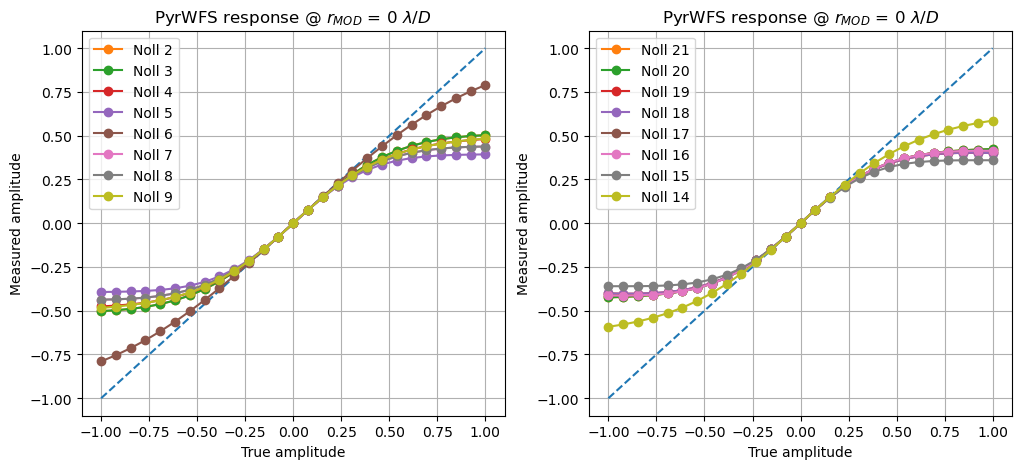

In [12]:
# Linearity check
Nmodes = 8
amp_vec = xp.linspace(-1,1,27,endpoint=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

intensities = xp.zeros((Nmodes,xp.shape(ccd.last_frame)[0],xp.shape(ccd.last_frame)[1]))
rev_intensities = xp.zeros((Nmodes,xp.shape(ccd.last_frame)[0],xp.shape(ccd.last_frame)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j
    rev_meas_amp = xp.zeros_like(amp_vec)

    zero = create_field_from_zernike_coefficients(mask, 1, 0)
    slope_null = sc.compute_slopes(zero, lambdaOverD, nPhotons=None)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        output_intensity = ccd.last_frame
        zern_reconstructed = Rec @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

        rev_zern = create_field_from_zernike_coefficients(mask, rev_zid, amp_vec[k])
        slopes = sc.compute_slopes(rev_zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        rev_output_intensity = ccd.last_frame
        zern_reconstructed = Rec @ slopes
        rev_meas_amp[k] = zern_reconstructed[rev_zid-2]
    
    intensities[j,:,:] = output_intensity
    rev_intensities[j,:,:] = rev_output_intensity

    plt.subplot(1,2,1)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(rev_meas_amp),'-o', label=f'Noll {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)

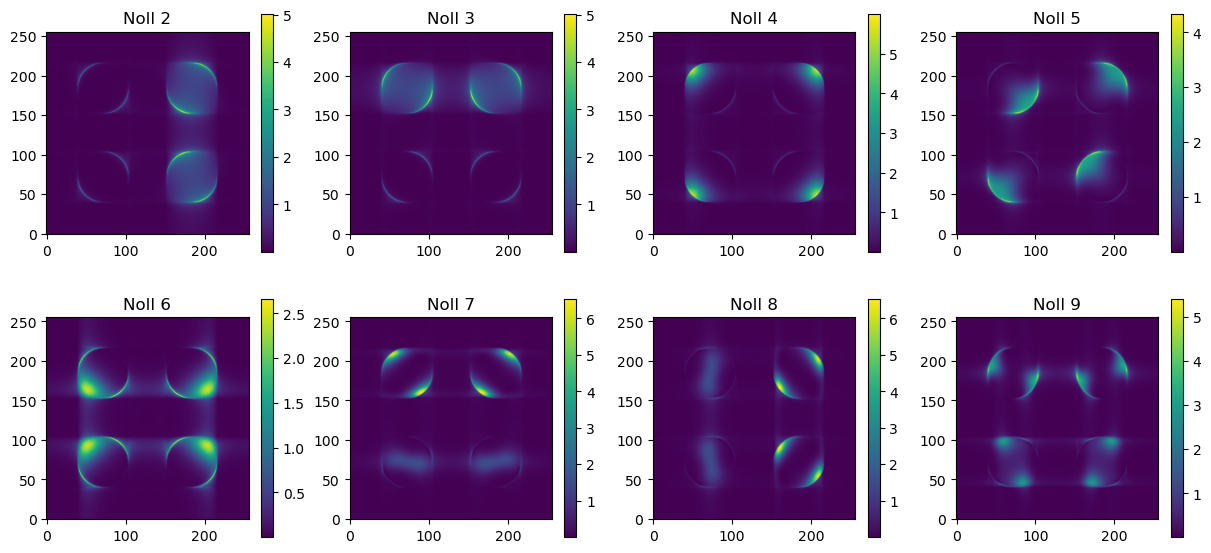

In [13]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(xp.asnumpy(toccd(intensities[i,:,:],ccd.detector_shape)),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')

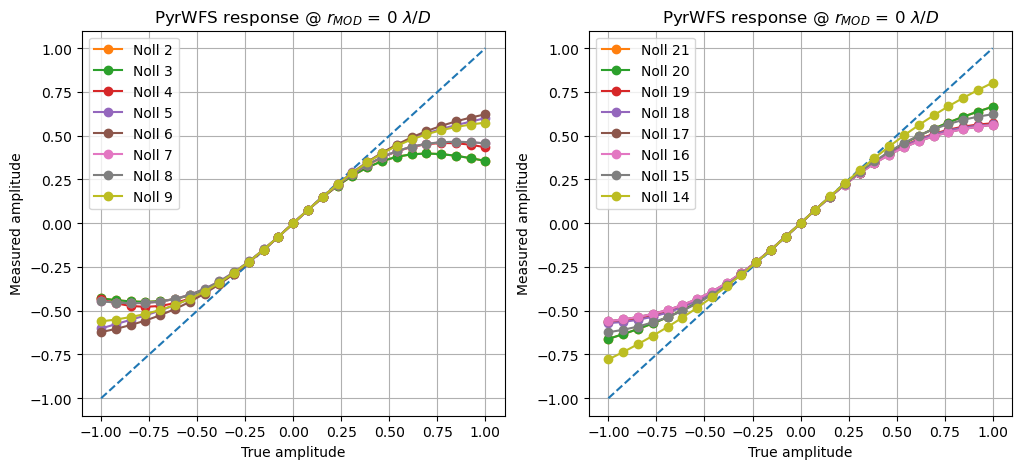

In [14]:
# Linearity check
Nmodes = 8
amp_vec = xp.linspace(-1,1,27,endpoint=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

intensities = xp.zeros((Nmodes,xp.shape(ccd.last_frame)[0],xp.shape(ccd.last_frame)[1]))
rev_intensities = xp.zeros((Nmodes,xp.shape(ccd.last_frame)[0],xp.shape(ccd.last_frame)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j
    rev_meas_amp = xp.zeros_like(amp_vec)

    zero = create_field_from_zernike_coefficients(mask, 1, 0)
    slope_null = roof_sc.compute_slopes(zero, lambdaOverD, nPhotons=None)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes = roof_sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        output_intensity = ccd.last_frame
        zern_reconstructed = Rec_roof @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

        rev_zern = create_field_from_zernike_coefficients(mask, rev_zid, amp_vec[k])
        slopes = roof_sc.compute_slopes(rev_zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        rev_output_intensity = ccd.last_frame
        zern_reconstructed = Rec_roof @ slopes
        rev_meas_amp[k] = zern_reconstructed[rev_zid-2]
    
    intensities[j,:,:] = output_intensity
    rev_intensities[j,:,:] = rev_output_intensity

    plt.subplot(1,2,1)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(rev_meas_amp),'-o', label=f'Noll {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)

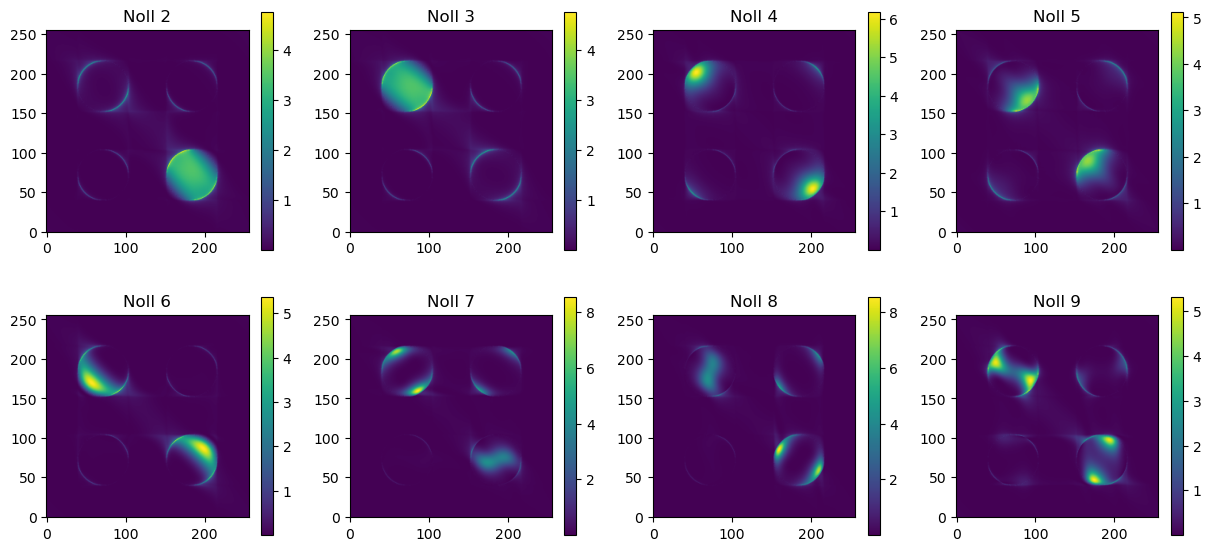

In [15]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(xp.asnumpy(toccd(intensities[i,:,:],ccd.detector_shape)),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')